In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

# Importing Dataset

The dataset we will use here to perform the analysis and build a predictive model is Bitcoin price data. We will use OHLC('Open','High','Low','Close') data from 17th july 2014 to 29th December 2022 which is for 8 years for the Bitcoin price.

In [28]:
df = pd.read_csv("Bitcoin.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [29]:
df.shape

(2683, 7)

From this, We got to know that there are 2683 rows of data available and for each row, we  have 7 different features or columns.

In [30]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2683.000000,2683.000000,2683.000000,2683.000000,2683.000000,2.683000e+03
mean,10989.900302,11286.625175,10662.957284,11003.581793,11003.581793,1.459304e+10
std,15902.616531,16331.949304,15408.069197,15908.160803,15908.160803,2.008458e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,601.778015,606.707001,596.048005,602.733490,602.733490,7.839140e+07
50%,6235.029785,6371.549805,6093.669922,6238.049805,6238.049805,4.999240e+09
75%,10316.638183,10495.605957,10067.539062,10317.936035,10317.936035,2.445092e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2683 entries, 0 to 2682
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2683 non-null   object 
 1   Open       2683 non-null   float64
 2   High       2683 non-null   float64
 3   Low        2683 non-null   float64
 4   Close      2683 non-null   float64
 5   Adj Close  2683 non-null   float64
 6   Volume     2683 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 146.9+ KB


# Exploratory Data Analysis

EDA is an approach to analyzing the data using visual techniques. It is used to discover trends, and patterns, or to check assumptions with the help of statistical summaries and graphical representations.

While performing the EDA of the Bitcoin Price data we will analyze how prices of the cryptocurrency have moved over the period of time and how the end of the quarters affects the prices of the currency.

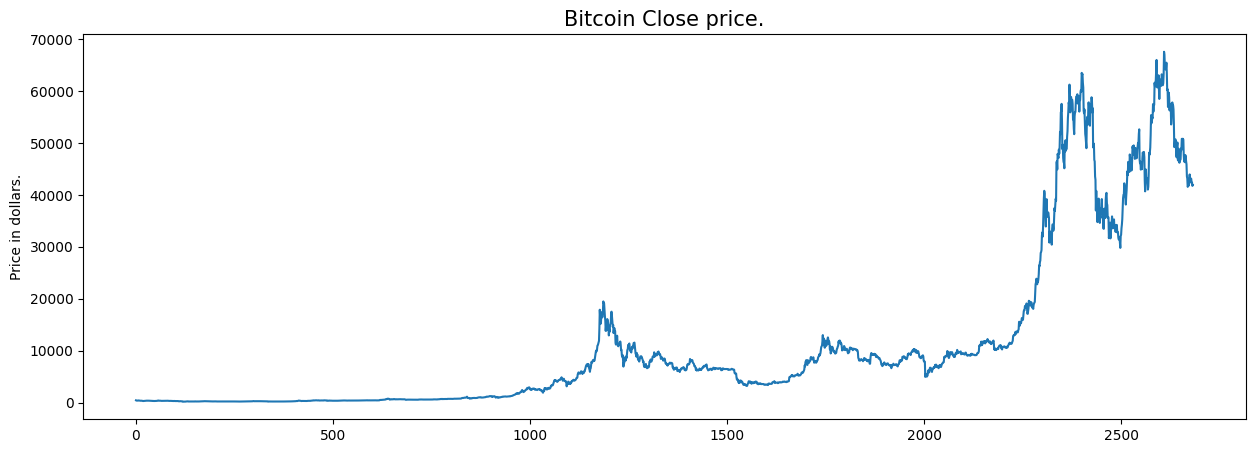

In [32]:
plt.figure(figsize=(15, 5))
plt.plot(df['Close'])
plt.title('Bitcoin Close price.', fontsize=15)
plt.ylabel('Price in dollars.')
plt.show()

The prices of the Bitcoin stocks are showing an upward trend as depicted by the plot of the closing price of the stocks.

In [33]:
df[df['Close'] == df['Adj Close']].shape, df.shape

((2683, 7), (2683, 7))

From here we can conclude that all the rows of columns ‘Close’ and ‘Adj Close’ have the same data. So, having redundant data in the dataset is not going to help so, we’ll drop this column before further analysis.

In [34]:
df = df.drop(['Adj Close'], axis=1)

Now let’s draw the distribution plot for the continuous features given in the dataset but before moving further let’s check for the null values if any are present in the data frame.

In [35]:
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0


This implies that there are no null values in the data set provided.

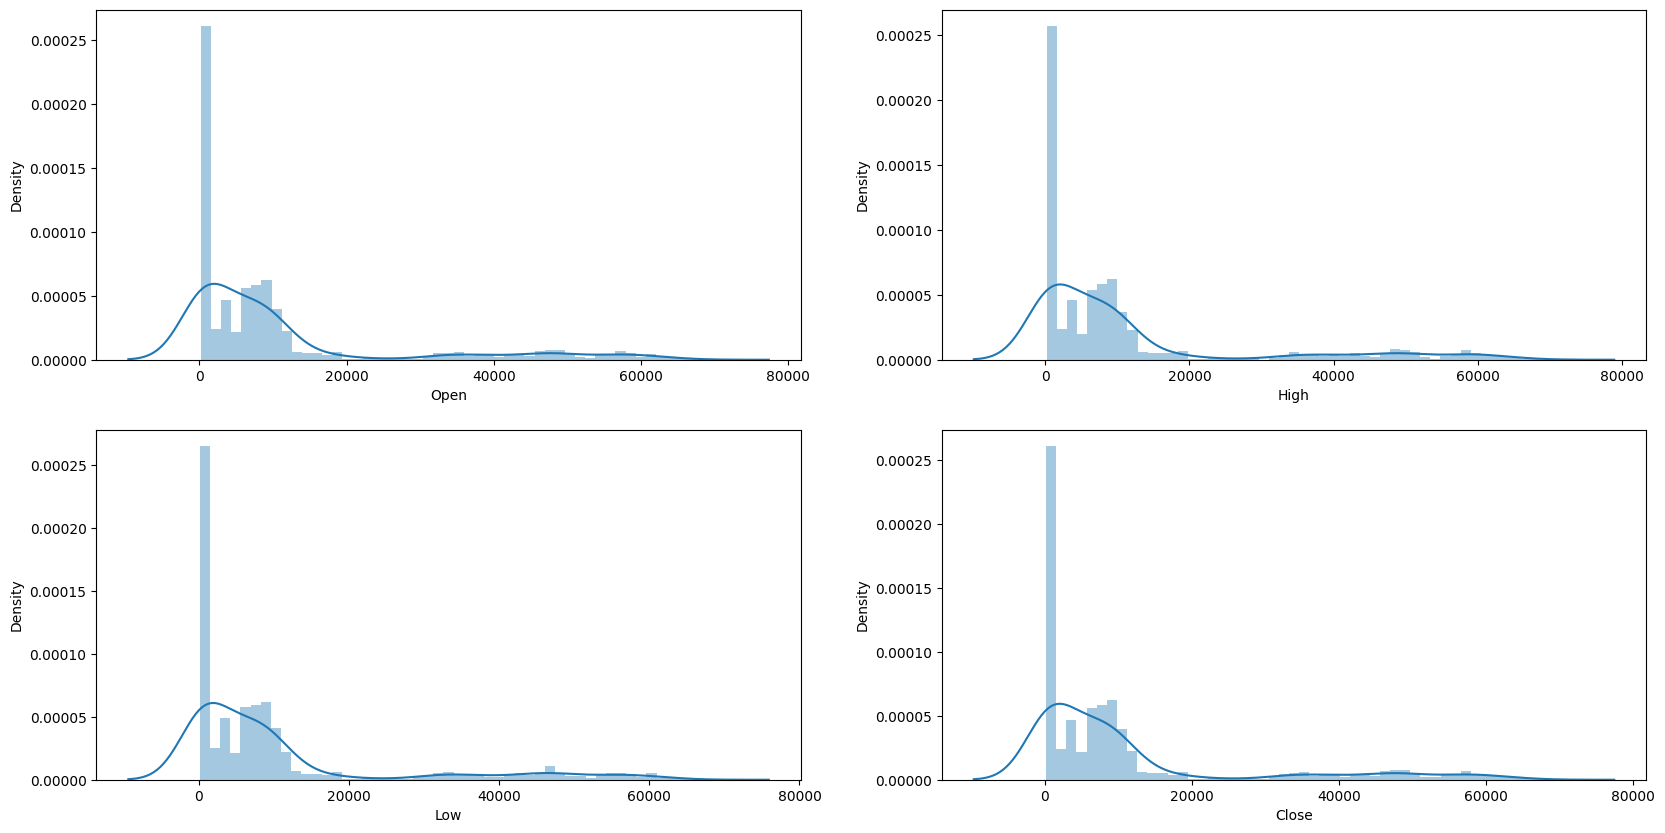

In [36]:
features = ['Open', 'High', 'Low', 'Close']

plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,2,i+1)
  sb.distplot(df[col])
plt.show()

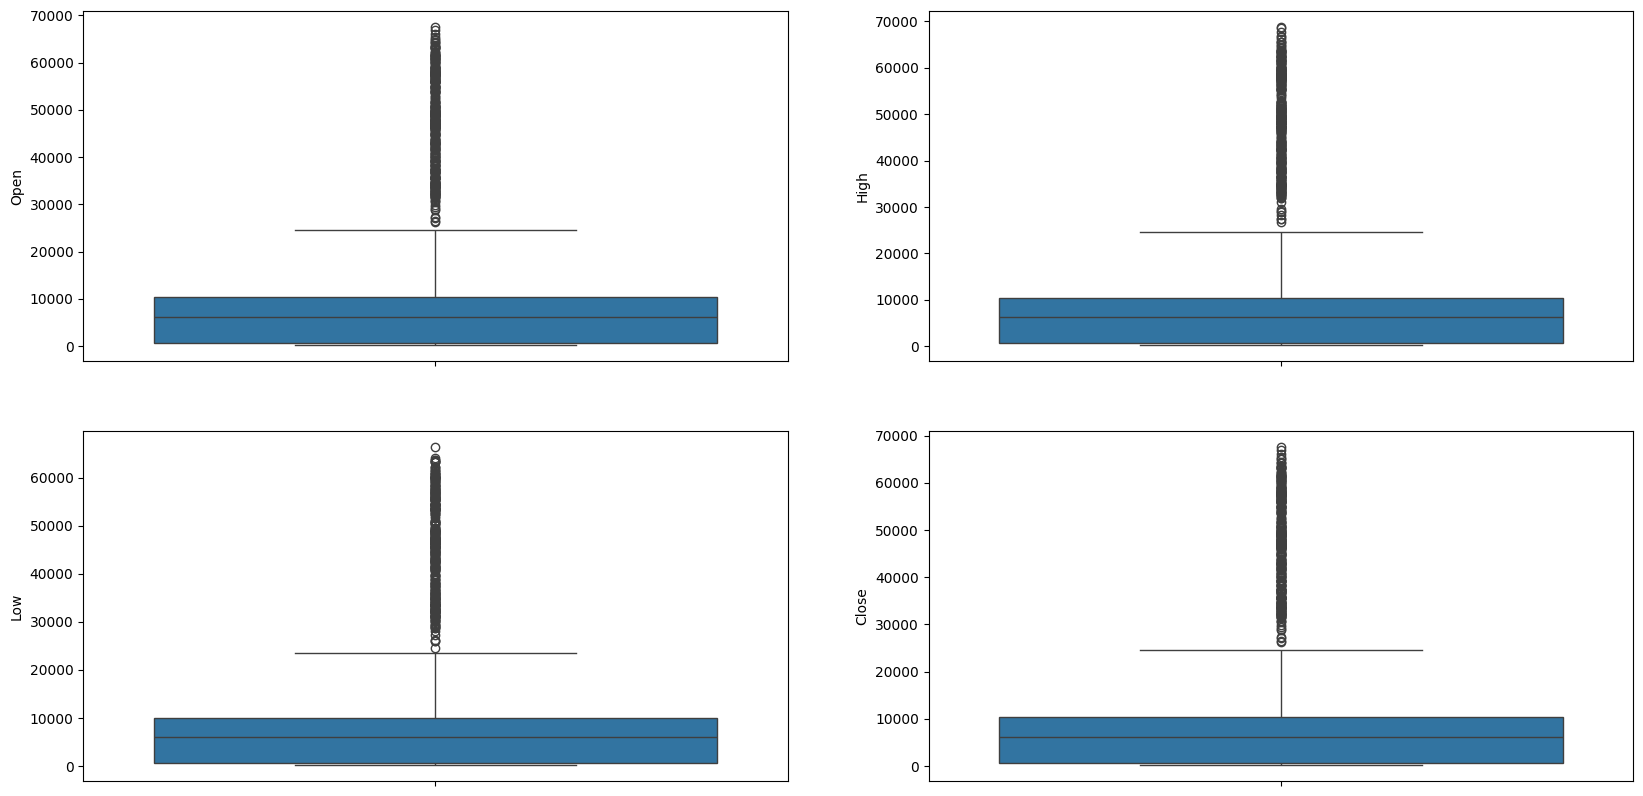

In [40]:
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,2,i+1)
  sb.boxplot(df[col])
plt.show()

There are so many outliers in the data which means that the prices of the stock have varied hugely in a very short period of time. Let’s check this with the help of a barplot.

# Feature Engineering

Feature Engineering helps to derive some valuable features from the existing ones. These extra features sometimes help in increasing the performance of the model significantly and certainly help to gain deeper insights into the data.

In [38]:
splitted = df['Date'].str.split('-', expand=True)

df['year'] = splitted[0].astype('int')
df['month'] = splitted[1].astype('int')
df['day'] = splitted[2].astype('int')

df.head()

,Date,Open,High,Low,Close,Volume,year,month,day
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,2014,9,17
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,2014,9,18
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,2014,9,19
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,2014,9,20
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,2014,9,21


Now we have three more columns namely ‘day’, ‘month’ and ‘year’ all these three have been derived from the ‘Date’ column which was initially provided in the data.

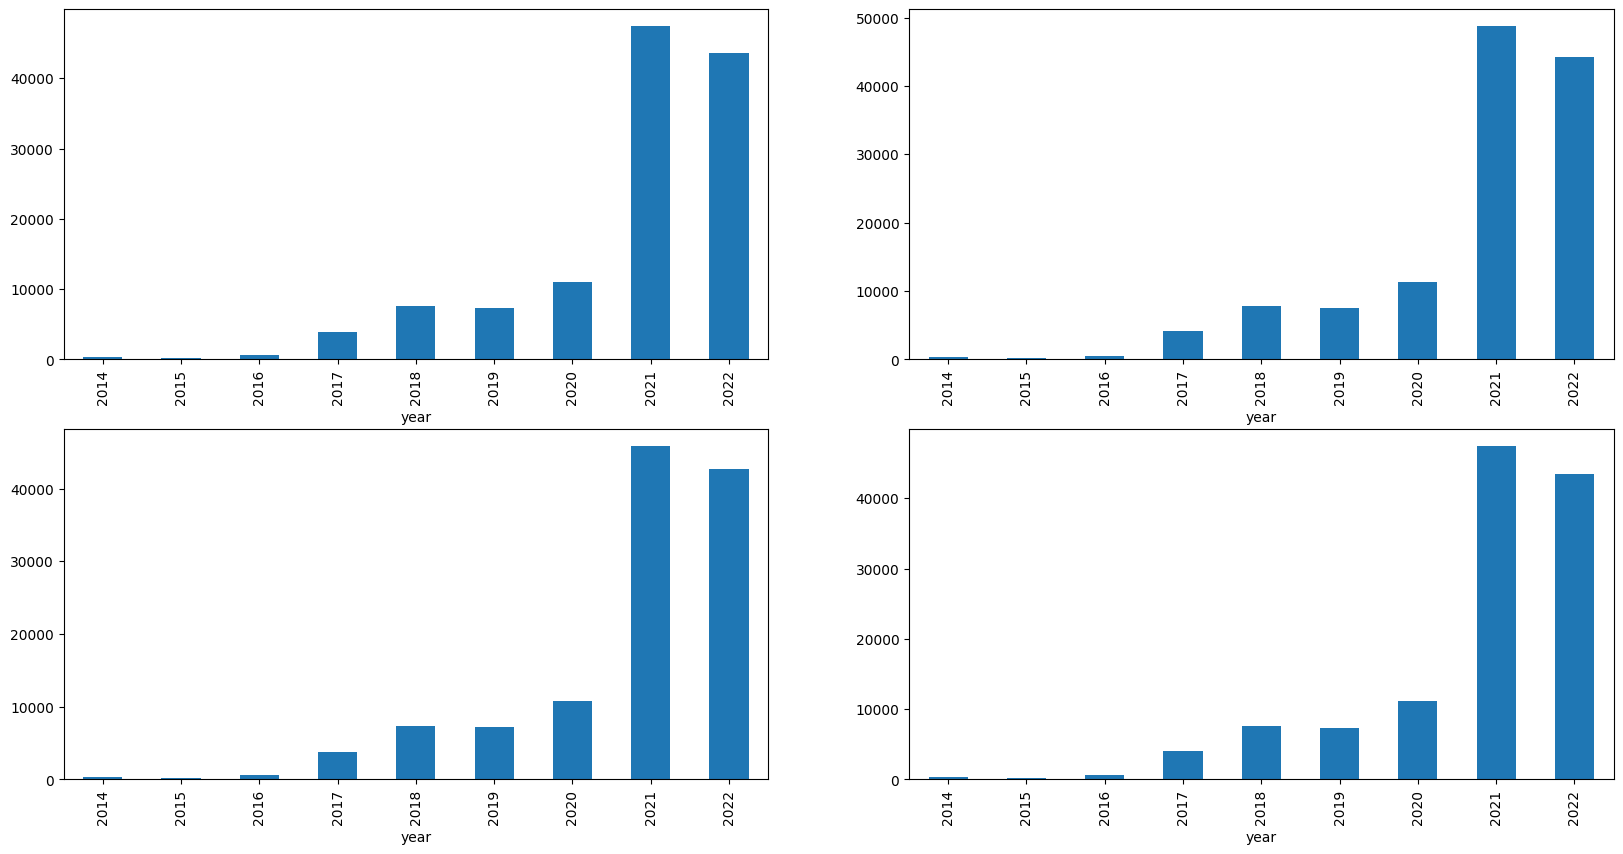

In [41]:
# Convert 'Date' column to datetime if it's not already
df['Date'] = pd.to_datetime(df['Date'])

# Calculate mean only on numeric columns
data_grouped = df.groupby('year').mean(numeric_only=True)

plt.subplots(figsize=(20,10))
for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
  plt.subplot(2,2,i+1)
  data_grouped[col].plot.bar()
plt.show()

Here we can observe why there are so many outliers in the data as the prices of bitcoin have exploded in the year 2021.

In [42]:
df['is_quarter_end'] = np.where(df['month']%3 == 0,1,0)
df.head()

,Date,Open,High,Low,Close,Volume,year,month,day,is_quarter_end
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,2014,9,17,1
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,2014,9,18,1
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,2014,9,19,1
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,2014,9,20,1
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,2014,9,21,1


In [44]:
df['open-close']  = df['Open'] - df['Close']
df['low-high']  = df['Low'] - df['High']
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

Above we have added some more columns which will help in the training of our model. We have added the target feature which is a signal whether to buy or not we will train our model to predict this only. But before proceeding let’s check whether the target is balanced or not using a pie chart.

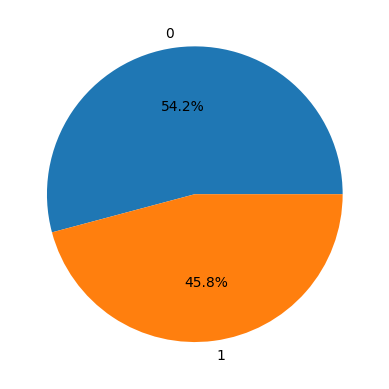

In [45]:
plt.pie(df['target'].value_counts().values,labels=[0, 1], autopct= '%1.1f%%')
plt.show()

When we add features to our dataset we have to ensure that there are no highly correlated features as they do not help in the learning process of the algorithm.

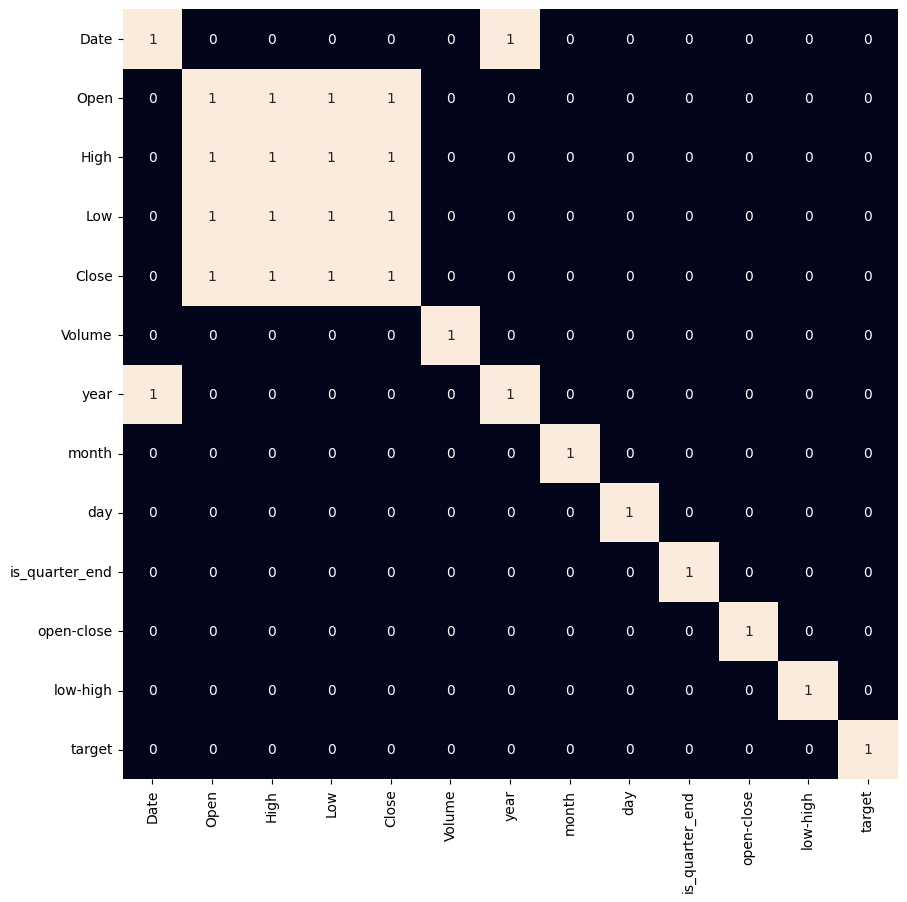

In [47]:
plt.figure(figsize=(10,10))
# As our concern is with the highly
# correlated features only so, we will visualize
# our heatmap as per that criteria only.
sb.heatmap(df.corr() > 0.9, annot=True, cbar=False)
plt.show()

From the above heatmap, we can say that there is a high correlation between OHLC which is pretty obvious, and the added features are not highly correlated with each other or previously provided features which means that we are good to go and build our model.

In [49]:
features = df[['open-close', 'low-high', 'is_quarter_end']]
target = df['target']

scaler = StandardScaler()
features = scaler.fit_transform(features)

X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.1, random_state=2022)
print(X_train.shape, X_valid.shape)

(2414, 3) (269, 3)


After selecting the features to train the model on we should normalize the data because normalized data leads to stable and fast training of the model. After that whole data has been split into two parts with a 90/10 ratio so, that we can evaluate the performance of our model on unseen data.

# Model Development and Evaluation

Now is the time to train some state-of-the-art machine learning models(Logistic Regression, Support Vector Machine, XGBClassifier), and then based on their performance on the training and validation data we will choose which ML model is serving the purpose at hand better.

For the evaluation metric, we will use the ROC-AUC curve but why this is because instead of predicting the hard probability that is 0 or 1 we would like it to predict soft probabilities that are continuous values between 0 to 1. And with soft probabilities, the ROC-AUC curve is generally used to measure the accuracy of the predictions.

In [50]:
models = [LogisticRegression(), SVC(kernel='poly', probability=True), XGBClassifier()]

for i in range(3):
  models[i].fit(X_train, Y_train)

  print(f'{models[i]} : ')
  print('Training Accuracy : ', metrics.roc_auc_score(Y_train, models[i].predict_proba(X_train)[:,1]))
  print('Validation Accuracy : ', metrics.roc_auc_score(Y_valid, models[i].predict_proba(X_valid)[:,1]))
  print()

LogisticRegression() : 
Training Accuracy :  0.5251799951412355
Validation Accuracy :  0.5395814376706096

SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.47457982729300563
Validation Accuracy :  0.5041515013648772

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training

Among the three models, we have trained XGBClassifier has the highest performance but it is pruned to overfitting as the difference between the training and the validation accuracy is too high. But in the case of the Logistic Regression, this is not the case.

Now let’s plot a confusion matrix for the validation data.

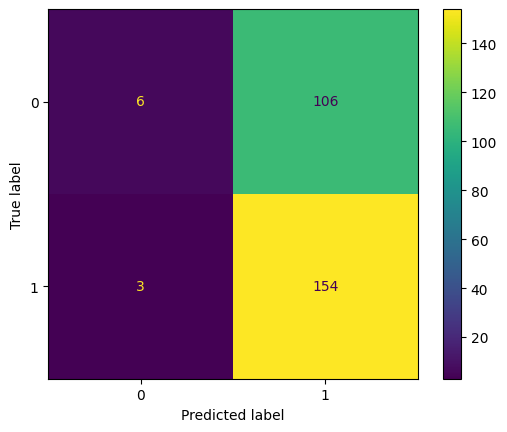

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Assuming 'models' and 'X_valid', 'Y_valid' are defined from your previous code
cm_display = ConfusionMatrixDisplay.from_estimator(models[0], X_valid, Y_valid)

plt.show()


